code by Park Seoyeon @seoyeon960406
- 2019-06
- tensorflow v1

## 형태소 분석 완료된 파일로 실행
- 형태소 분석은 울산대학교의 UTagger를 사용했음

In [1]:
def open_tokenized_file(filename):
    tokens, labels = [], []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.replace('\n', '').split('\t')
            tokens.append(line[0].split())
            labels.append(line[1])
    return tokens, labels 

In [2]:
train_tokens, train_labels = open_tokenized_file('./data_in/tokenized_rating_train.txt')
test_tokens, test_labels = open_tokenized_file('./data_in/tokenized_rating_test.txt')

In [3]:
print(train_tokens[0], train_labels[0])

['흠__03/NNG', './SF', './SF', './SF', '포스터__01/NNG', '보__01/VV', '고/EC', '초딩/NNG', '영화__01/NNG', '줄__04/NNB', './SF', './SF', './SF', './SF', '오버/NNG', '연기__09/NNG', '조차/JX', '가볍/VA', '지/EC', '않/VX', '구나/EF'] 1


## word2vec 학습
- 학습한 모델이 있을 경우, import gensim을 제외한 셀은 skip 가능

In [4]:
import gensim

In [5]:
model = gensim.models.Word2Vec(sentences=train_tokens, size=300, sg=1, window=5)
for epoch in range(5):
    model.train(train_tokens, total_words = model.corpus_count, epochs=model.iter)

C:\Users\klplab\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
word_vectors = model.wv
vocabs = word_vectors.vocab.keys()

In [7]:
print(list(vocabs)[:100]) #학습된 단어

['흠__03/NNG', './SF', '포스터__01/NNG', '보__01/VV', '고/EC', '초딩/NNG', '영화__01/NNG', '줄__04/NNB', '오버/NNG', '연기__09/NNG', '조차/JX', '가볍/VA', '지/EC', '않/VX', '구나/EF', '너무__01/MAG', '이/VCP', '다/EC', '그리하/VV', '여서/EC', '는/ETM', '것__01/NNB', '을/JKO', '추천하__02/VV', 'ㄴ다/EF', '교도소/NNG', '이야기/NNG', '구먼/EC', '솔직히/MAG', '재미__01/NNG', '는/JX', '없__01/VA', '다/EF', '평점__02/NNG', '조정__09/NNG', '의/JKG', '익살스럽/VA', 'ㄴ/ETM', '연기__10/NNG', '가/JKS', '돋보이/VV', '었/EP', '던/ETM', '!/SF', '스파이더맨/NNP', '에서/JKB', '늙/VV', '어/EC', '보이__01/VV', '기/ETN', '만/JX', '하__01/VX', '였/EP', '커스틴/NNP', '너무나/MAG', '도/JX', '이쁘/VA', '막__01/MAG', '떼__01/VV', '3/SN', '세__13/NNB', '부터/JX', '초등학교/NNG', '1/SN', '8/SN', 'ㅋㅋㅋ/NNG', '별__01/NNG', '반__07/NNG', '개__03/NNG', '아깝/VA', 'ㅁ/ETN', '원작/NNG', '긴장감/NNG', '제대로/MAG', '살리/VV', '내__02/VX', '못하/VX', '욕__02/NNG', '나오/VV', 'ㄴ다/EC', '이응경/NNP', '생활/NNG', '이/JKS', '몇/MM', '년__02/NNB', 'ㄴ지/EF', '정말__01/MAG', '발__01/NNG', '로/JKB', '하__01/VV', '여도/EC', '그것/NP', '보다/JKB', 'ㄴ/JX', '납치/NNG', '반복__01/NN

In [8]:
model.most_similar('짜증/NNG')

C:\Users\klplab\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('열불/NNG', 0.5626382827758789),
 ('멀미__01/NNG', 0.5588407516479492),
 ('성질/NNG', 0.5413709878921509),
 ('신경질/NNG', 0.5390133261680603),
 ('나__01/VV', 0.5337879657745361),
 ('구역질/NNG', 0.5212204456329346),
 ('솟구치/VV', 0.516242265701294),
 ('발정__01/NNG', 0.49881452322006226),
 ('뻗치/VV', 0.4975906014442444),
 ('진절머리/NNG', 0.4962601363658905)]

In [10]:
model.save('movie_word2vec300.model')

## word2vec 관련 함수

In [9]:
import numpy as np

In [10]:
def load_model(model_name):
    model = gensim.models.word2vec.Word2Vec.load(model_name)
    return model

In [11]:
# 문장(형태소 토큰으로 이루어진 list)을 벡터로 변환
# OOV : Out of Vovab(학습되지 않은 단어)
def corpus2vec(model_name, doc):
    word_vec = []
    model = load_model(model_name)
    for sent in doc:
        sub = []
        for word in sent:
            if(word in model.wv.vocab):
                sub.append(model.wv[word])
            else:
                sub.append(np.random.uniform(-0.25,0.25,300)) ## used for OOV words
        word_vec.append(sub)
        
    return np.array(word_vec)

In [12]:
# 학습데이터 중 가장 긴 문장의 길이에 맞게 제로 패딩
def zero_padding(train_batch_X, batch_size, maxseq_length, vector_size):  
    zero_pad = np.zeros((batch_size, maxseq_length, vector_size))
    for i in range(batch_size):
        try:
            zero_pad[i,:np.shape(train_batch_X[i])[0],:np.shape(train_batch_X[i])[1]] = train_batch_X[i]
        except:
            continue
    return zero_pad

In [13]:
# 레이블을 원핫으로 표현(부정(0)->[1, 0] / 긍정(1)->[0, 1])
def one_hot(labels):
    result = []
    for label in labels:
        line = np.zeros(2)
        line[int(label)] = 1
        result.append(line)
    return np.array(result)

## 감성분석 모델 학습
- tensorflow v1 사용 중
- BiLSTM + attention 메커니즘

- reference
- https://github.com/MSWon/Sentimental-Analysis
- https://github.com/graykode/nlp-tutorial/blob/master/archive/tensorflow/v1/4-3.Bi-LSTM(Attention)/Bi-LSTM(Attention).py

In [14]:
import tensorflow as tf
import random

In [15]:
batch_size = 256
vector_size = 300
seq_list = [len(x) for x in train_tokens]
maxseq_length = max(seq_list) #140
learning_rate = 0.001
lstm_units = 128
num_class = 2 # 분류할 클래스 수(긍정, 부정)
training_epochs = 100

In [16]:
def reset_graph(seed=0):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    
reset_graph()

In [17]:
len(train_tokens), len(train_labels)

(149997, 149997)

In [18]:
tmp = [[x, y] for x, y in zip(train_tokens, train_labels)]
random.shuffle(tmp)

In [19]:
# 학습 데이터 순서 섞기
train_tokens = [line[0] for line in tmp]
train_labels = [line[1] for line in tmp]

In [20]:
index = int(len(train_tokens)*0.9)

In [21]:
# 학습 데이터 중 10%를 검증 데이터로 사용
train_tokens, val_tokens = train_tokens[:index], train_tokens[index:]
train_labels, val_labels = train_labels[:index], train_labels[index:]

In [22]:
train_X = corpus2vec('movie_word2vec300.model',train_tokens)
train_Y = one_hot(train_labels)
train_lens = np.array([len(seq) for seq in train_X])

In [23]:
valid_X = corpus2vec('movie_word2vec300.model',val_tokens)
valid_Y = one_hot(val_labels)
val_lens = np.array([len(seq) for seq in valid_X])

In [24]:
X = tf.placeholder(tf.float32,[None, maxseq_length, vector_size])
Y = tf.placeholder(tf.float32,[None, num_class])

keep_prob = tf.placeholder(tf.float32)
seq_len = tf.placeholder(tf.int32, shape=[None])

In [25]:
# lstm cell 2개를 생성합니다. 각 셀은 Dropout을 시켜줘 Overfitting을 방지합니다.
lstm_fw_cell = tf.nn.rnn_cell.LSTMCell(num_units = lstm_units, state_is_tuple = True)
lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_fw_cell, output_keep_prob=keep_prob)
lstm_bw_cell = tf.nn.rnn_cell.LSTMCell(num_units = lstm_units, state_is_tuple = True)
lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_bw_cell, output_keep_prob=keep_prob)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [26]:
W = tf.get_variable(name="W", shape=[2 * lstm_units, num_class],
                                dtype=tf.float32, initializer = tf.contrib.layers.xavier_initializer())
b = tf.get_variable(name="b", shape=[num_class], dtype=tf.float32,
                                initializer=tf.zeros_initializer())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [27]:
output, states = tf.nn.bidirectional_dynamic_rnn(lstm_fw_cell, lstm_bw_cell,
                                                 dtype=tf.float32, inputs = X, sequence_length=seq_len)

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
## concat fw, bw final states
outputs = tf.concat([output[0], output[1]], 2)
final_hidden_state = tf.concat([states[1][0], states[1][1]], 1)
final_hidden_state = tf.expand_dims(final_hidden_state, 2)

In [29]:
# attn_weights : [batch_size, n_step]
attn_weights = tf.squeeze(tf.matmul(outputs, final_hidden_state), 2)
soft_attn_weights = tf.nn.softmax(attn_weights, 1)
tf.transpose(outputs, [0, 2, 1])

<tf.Tensor 'transpose:0' shape=(?, 256, 140) dtype=float32>

In [30]:
context = tf.matmul(tf.transpose(outputs, [0, 2, 1]), tf.expand_dims(soft_attn_weights, 2)) # context : [batch_size, n_hidden * num_directions(=2), 1]
context = tf.squeeze(context, 2) # [batch_size, n_hidden * num_directions(=2)]

In [31]:
logit = tf.matmul(context, W) + b

In [32]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = logit, labels = Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [33]:
prediction = tf.nn.softmax(logit)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [34]:
init = tf.global_variables_initializer()

In [37]:
modelName = "./sentiment-LSTM_model.ckpt"
saver = tf.train.Saver()

In [38]:
train_acc, train_loss = [], []
val_acc, val_loss = [], []

best_accuracy = 0
max_checks = 5
checks_without_progress = 0

In [39]:
def shuffle_batch(X, y, seq_len, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // (batch_size)
    X_, y_, len_ = X[rnd_idx], y[rnd_idx], seq_len[rnd_idx]
    for step in range(n_batches):
        start = step*batch_size
        X_batch, y_batch, len_batch = X_[start:start+batch_size], y_[start:start+batch_size], len_[start:start+batch_size]
        yield X_batch, y_batch, len_batch

In [40]:
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):
        avg_acc, avg_loss = [] , []
        print('=====TRAIN======')
        for X_batch, y_batch, len_batch in shuffle_batch(train_X, train_Y, train_lens, batch_size):
            if len(X_batch)!=batch_size:
                break
                
            X_batch =zero_padding(X_batch, batch_size, maxseq_length, vector_size)
            
            los, _, acc = sess.run([loss, optimizer, accuracy],
                        feed_dict={X:X_batch, Y:y_batch, seq_len:len_batch, keep_prob:0.75})
            
            avg_acc.append(acc)
            avg_loss.append(los)
        train_acc.append(sum(avg_acc)/len(avg_acc))
        train_loss.append(sum(avg_loss)/len(avg_loss))
        print('Eopch:{:2d}, cost={:9f}'.format((epoch+1), sum(avg_loss)/len(avg_loss)))
        print('Train Accuracy:', sum(avg_acc)/len(avg_acc))
        
        avg_acc, avg_loss = [] , []
        print('=====VALID======')
        for val_batch_X, val_batch_Y, val_batch_len in shuffle_batch(valid_X, valid_Y, val_lens, batch_size):
            if len(val_batch_X)!=batch_size:
                break
                
            val_batch_X =zero_padding(val_batch_X, batch_size, maxseq_length, vector_size)
            
            v_los = loss.eval(feed_dict={X:val_batch_X, Y:val_batch_Y, seq_len:val_batch_len, keep_prob:1.0})
            v_acc = accuracy.eval(feed_dict={X:val_batch_X, Y:val_batch_Y, seq_len:val_batch_len, keep_prob:1.0})
            
            avg_acc.append(v_acc)
            avg_loss.append(v_los)
        val_acc.append(sum(avg_acc)/len(avg_acc))
        val_loss.append(sum(avg_loss)/len(avg_loss))
        print('Eopch:{:2d}, cost={:9f}'.format((epoch+1), sum(avg_loss)/len(avg_loss)))
        print('Validation Accuracy:', sum(avg_acc)/len(avg_acc))
        
        v_avg_acc = sum(avg_acc)/len(avg_acc)
        # 조기종료를 위한 부분
        # 5번 이상 정확률이 떨어진 경우, 종료
        if v_avg_acc>best_accuracy:
            save_path = saver.save(sess, modelName)
            best_accuracy = v_avg_acc
            checks_without_progress = 0
        else:
            checks_without_progress+=1
            if checks_without_progress >= max_checks:
                print('조기종료')
                break
                
        print()

=====TRAIN======
Eopch: 1, cost= 0.388212
Train Accuracy: 0.8269390417457305
=====VALID======
Eopch: 1, cost= 0.343198
Validation Accuracy: 0.8485991379310345

=====TRAIN======
Eopch: 2, cost= 0.336359
Train Accuracy: 0.8537491105313093
=====VALID======
Eopch: 2, cost= 0.314389
Validation Accuracy: 0.8647629310344828

=====TRAIN======
Eopch: 3, cost= 0.312698
Train Accuracy: 0.8645265061669829
=====VALID======
Eopch: 3, cost= 0.304442
Validation Accuracy: 0.8721713362068966

=====TRAIN======
Eopch: 4, cost= 0.295578
Train Accuracy: 0.8721759369070209
=====VALID======
Eopch: 4, cost= 0.297655
Validation Accuracy: 0.8752693965517241

=====TRAIN======
Eopch: 5, cost= 0.281475
Train Accuracy: 0.8788469520872866
=====VALID======
Eopch: 5, cost= 0.295354
Validation Accuracy: 0.8731815732758621

=====TRAIN======
Eopch: 6, cost= 0.266372
Train Accuracy: 0.8850213472485768
=====VALID======
Eopch: 6, cost= 0.293029
Validation Accuracy: 0.8780980603448276

=====TRAIN======
Eopch: 7, cost= 0.25191

In [44]:
#조기종료 시접
early_stop = val_acc.index(max(val_acc))
print(early_stop)

7


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

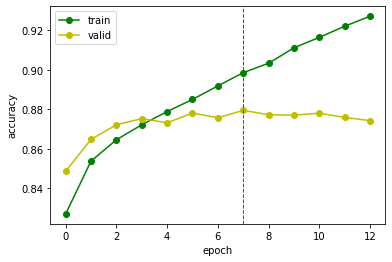

In [46]:
# 조기종료 시점
plt.plot(train_acc, color='g', marker='o')
plt.plot(val_acc, color='y', marker='o')
plt.axvline(x=early_stop, color='r', linestyle='--', linewidth=1)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'])

## 학습한 모델 성능 평가

In [47]:
test_X = corpus2vec('movie_word2vec300.model',test_tokens)
test_Y = one_hot(test_labels)
test_lens = np.array([len(seq) for seq in test_X])

In [50]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, modelName)
    
    print('=====TEST=====')
    avg_acc, avg_loss = [] , []
    for X_batch, y_batch, len_batch in shuffle_batch(test_X, test_Y, test_lens, batch_size):
        if len(X_batch)!=batch_size:
            break

        X_batch =zero_padding(X_batch, batch_size, maxseq_length, vector_size)

        los, _, acc = sess.run([loss, optimizer, accuracy],
                        feed_dict={X:X_batch, Y:y_batch, seq_len:len_batch, keep_prob:1.0})
            
        avg_acc.append(acc)
        avg_loss.append(los)
     
    print('cost={:9f}'.format(sum(avg_loss)/len(avg_loss)))
    print('Test Accuracy:', sum(avg_acc)/len(avg_acc))

INFO:tensorflow:Restoring parameters from ./sentiment-LSTM_model.ckpt
=====TEST=====
cost= 0.299957
Test Accuracy: 0.8685496794871795


## 입력 문장 테스트
- utagger를 이용한 형태소 분석을 거친 sample 문장들

In [53]:
samples = [['B/SL', '급__04/NNG', '이하__02/NNG', '전편__03/NNG', '보다/JKB', '퇴보/NNG', '되/XSV', 'ㄴ/ETM', 'CG/SL', ',/SP', '중구난방/NNG', '식__09/XSN', '연출__02/NNG', ',/SP', '러닝/NNG', '타임/NNG', '늘리/VV', '기/ETN', '위하__01/VV', 'ㄴ/ETM', '쓸모없/VA', '는/ETM', '컷/NNG', ',/SP'],
          ['오__01/VV', '아/EC', '이것/NP', '이/JKS', '얼마/NNG', '만__01/NNB', '에/JKB', '히어로/NNG', '무비__88/NNG', '이/VCP', '냐/EC', '가슴__01/NNG', '이/JKS', '쥰/NNG', '나/JC', '웅장하/VA', '여/EC', '지__04/VX', 'ㄴ다/EF']]

In [60]:
sess.run(init)
saver.restore(sess, modelName)

INFO:tensorflow:Restoring parameters from ./sentiment-LSTM_model.ckpt


In [87]:
def sentiment_prediction(tokens):
    #tokens = utagger(sentence)
    embedded = corpus2vec('movie_word2vec300.model', [tokens])
    padded = zero_padding(embedded, batch_size, maxseq_length, vector_size)
    
    global sess
    #prob = sess.run(prediction, feed_dict={})
    #prob[0]은 입력 토큰열에 대한 예측 확률
    #prob[0] = [부정확률, 긍정확률]
    result =  sess.run(tf.argmax(prediction, 1), feed_dict={X:padded, seq_len:len_batch, keep_prob:1.0})

    if (result[0]==1):
        print("긍정입니다.")
    else:
        print('부정입니다.')

In [88]:
sentiment_prediction(samples[0])

부정입니다.


In [89]:
sentiment_prediction(samples[1])

긍정입니다.
